# Battle of neighborhoods - Analysis of vegan and vegetarian restaurants in NYC

IMPORTANT NOTE: TO SEE THE CHOROPLETH MAP PLEASE OPEN THE FOLLOWING LINK TO MY IBM-WATSON JUPYTER NOTEBOOK:  
https://eu-de.dataplatform.cloud.ibm.com/analytics/notebooks/v2/8a40edad-f4a0-46c6-819d-3393d52fdad8/view?access_token=c07d2a7c955e067dc0a54d56ac54c5cdd10cdcb2137e6487a7ab862ece069404

## Introduction / The business problem

In the past years the share of people having a vegetarian or vegan diary has increased worldwirde. In the US the market for vegan food products only has reached 2.22 bn USD. An important reason contributing to this development is the rising awareness of the ecological and environmental consequences of meat consumption. As the world population is increasing and hence the demand for meat worldwide as well, a lot of people switch to alternative nutrition behaviors. This development creates new chances in a growing market. One of these might be to open a vegetarian or vegan restaurant. Opening a restaurant comes with a lot of risks and requires a well thought business plan that contains and a carefull study of the supply and demand in the specific area. This analysis will focus on the supply side of vegetarian and vegan restaurants in New York City and will provide an overview of the market in each borough of NYC. This can also be useful for tourists who just want to explore the vegan and vegetarian food culture in Big Apple. I will use venue data obtained using the Foursquare API to analyize the number of vegetarian and vegan restaurants in each borough. Additionally, I will create a density map where I will show how many vegetarian and vegan restaurants exist compared to the total number of restaurants in the specific borough. This helps to identify if their is already a solid supply of vegetarian and vegan food or if shortage can be identified.

## Data

The data used for this analysis comes from three different sources.
- data for each borough, neighborhood as well as latitude and longitude coordinates come from <b> IBM's cognative class datasets </b> and can be downloaded under the following link: https://cocl.us/new_york_dataset
- information about the venues in each neighborhood can be obtained from the <b> Foursquare API </b> which requires a developer account
- graphical data, specifically the geojson data for plotting everything in a choropleth map can be downloaded from the <b> webside of the city of New York </b> under the following link: https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=GeoJSON 
  
These important python packages will help to make use of the yet unstructured, raw data:
- <b>pandas</b> to easily read in json files and create data frames
- <b>seaborn</b>, <b>matplotlib</b> and <b>folium</b> to create meaningful plots that will help to visualize the data
- <b>geopy</b> to obtain the coordinates of NYC

## Methodology

In order to tackle the business problem described in the introduction section, I will perform a mainly descriptive analysis of the data. The steps taken are summarized below:  

1. Load all packages needed
2. Define all functions needed.
3. load the borough/neighborhood data of NYC and adjust it to my needs
4. load and add the venue data using the foursquare API
5. start of the descriptive analysis using tables and barplots
6. calculation of the density of vegetarian / vegan restaurants in NYC
7. graphical visualization using the folium package and its choropleth map

In [1]:
#packages needed
import pandas as pd
import requests
#!conda install -c conda-forge folium=0.5.0 --yes # if folium is not yet install uncomment
import folium # map rendering library
import geopy
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/DSX-Python35

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    altair-2.2.2               |           py35_1         462 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    certifi-2018.8.24          |        py35_1001         139 KB  conda-forge
    openssl-1.0.2r             |       h14c3975_0         3.1 MB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    ca-certificates-2019.3.9   |       hecc5488_0         146 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.0 MB

The following NEW packages will

In [10]:
# The code was removed by Watson Studio for sharing.

In [11]:
#Function to obtain the neighborhood data from the URL
def load_ny_data(url):
    resp=requests.get(url).json()
    features_data=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

    # instantiate the dataframe
    neighborhoods = pd.DataFrame(columns=column_names)
    for data in features_data:
        borough = neighborhood_name = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]

        neighborhoods = neighborhoods.append({'Borough': borough,
                                              'Neighborhood': neighborhood_name,
                                              'Latitude': neighborhood_lat,
                                              'Longitude': neighborhood_lon}, ignore_index=True)


    return neighborhoods

In [16]:
def getNearbyVenues(boroughs, neighborhoods, latitudes, longitudes, radius=500, LIMIT = 100):
    
    VERSION = '20180605' # Foursquare API version
    venues_list=[]
    for borough, neighborhood, lat, lng in zip(boroughs, neighborhoods, latitudes, longitudes):
        print(neighborhood)    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, #Use your Foursquare Client ID
            CLIENT_SECRET, #Use your Foursquare Client Secret
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        for v in results:
            try:
                venue_id=v['venue']['id']
                venue_name=v['venue']['name']
                venue_category=v['venue']['categories'][0]['name']
                venues_list.append([borough,neighborhood,venue_id,venue_name,venue_category])
            except KeyError:
                pass
    
    column_names = ['Borough', 'Neighborhood', 'Venue_ID', 'Venue_Name', 'Cat_Name']
    nearby_venues = pd.DataFrame(venues_list, columns=column_names)
    
    return(nearby_venues)

In [13]:
#load all data needed 
ny_borough_url = 'https://cocl.us/new_york_dataset'
neighborhood_data = load_ny_data(ny_borough_url)
ny_geo_data=requests.get('https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=GeoJSON').json()

#### The structure of the borough/neighborhood dataframe looks as follows:

In [14]:
neighborhood_data.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [17]:
manhattan_venues = getNearbyVenues(boroughs=neighborhood_data['Borough'],
                                   neighborhoods=neighborhood_data['Neighborhood'],
                                   latitudes=neighborhood_data['Latitude'],
                                   longitudes=neighborhood_data['Longitude']
                                  )

print('All venues downloaded successfully')

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

#### After loading and adding the venue data the following dataframe is obtained consisting of 10345 rows  
Important to note is that only venues within a radius of 500 around the centre of each neighborhood have been loaded

In [18]:
manhattan_venues.head()

Borough Neighborhood                  Venue_ID  \
0   Bronx    Wakefield  4c537892fd2ea593cb077a28   
1   Bronx    Wakefield  4d6af9426107f04dedeb297a   
2   Bronx    Wakefield  4c783cef3badb1f7e4244b54   
3   Bronx    Wakefield  508af256e4b0578944c87392   
4   Bronx    Wakefield  4c25c212f1272d7f836385c5   

                                Venue_Name              Cat_Name  
0                         Lollipops Gelato          Dessert Shop  
1                                 Rite Aid              Pharmacy  
2                         Carvel Ice Cream        Ice Cream Shop  
3  Cooler Runnings Jamaican Restaurant Inc  Caribbean Restaurant  
4                                  Dunkin'            Donut Shop

In [19]:
manhattan_venues.shape

(10344, 5)

#### Now the veggi restaurants in each neighborhood will be counted

In [20]:
count_table = manhattan_venues[manhattan_venues['Cat_Name']=='Vegetarian / Vegan Restaurant'].groupby('Neighborhood').count()
count_table

Borough  Venue_ID  Venue_Name  Cat_Name
Neighborhood                                              
Astoria                  1         1           1         1
Bushwick                 2         2           2         2
Carnegie Hill            1         1           1         1
Carroll Gardens          1         1           1         1
Chelsea                  1         1           1         1
Chinatown                1         1           1         1
Clinton                  1         1           1         1
Clinton Hill             1         1           1         1
East Village             3         3           3         3
East Williamsburg        2         2           2         2
Flatiron                 2         2           2         2
Fort Greene              1         1           1         1
Fresh Meadows            1         1           1         1
Grasmere                 1         1           1         1
Greenpoint               1         1           1         1
Greenwich Village        1         1           1         1
Lenox Hill               1         1           1         1
Little Italy             1         1           1         1
Midtown South            1         1           1         1
Murray Hill              1         1           1         1
North Side               3         3           3         3
Prospect Heights         1         1           1         1
Queensboro Hill          1         1           1         1
Ridgewood                1         1           1         1
Rockaway Beach           1         1           1         1
Soho                     2         2           2         2
South Side               1         1           1         1
Sutton Place             1         1           1         1
Tribeca                  1         1           1         1
Upper East Side          2         2           2         2
Upper West Side          3         3           3         3
Williamsburg             1         1           1         1

In [21]:
count_table.shape

(32, 4)

In [22]:
manhattan_venues['Neighborhood'].nunique()

300

In [23]:
print("The total number of neighborhoods is {}".format(manhattan_venues['Neighborhood'].nunique()))
print("The total number of neighborhoods that have veggi restuarants is {}".format(count_table.shape[0]))
print("That is a share of {} percent".format(32/300*100))

The total number of neighborhoods is 300
The total number of neighborhoods that have veggi restuarants is 32
That is a share of 10.666666666666668 percent


#### As can be seen only 32 out of 300 neighborhoods have veggi restaurants within the 500m radius

Now let's groupby Borough and count the number of veggi raustaurants in each neighborhood, grouped by borough.  
Than plot the 10 neighborhoods with the most veggi restaurants per neighborhood

In [36]:
manhattan_venues[manhattan_venues['Cat_Name']=='Vegetarian / Vegan Restaurant'].groupby(['Borough','Neighborhood']).count()

Venue_ID  Venue_Name  Cat_Name
Borough       Neighborhood                                     
Brooklyn      Bushwick                  2           2         2
              Carroll Gardens           1           1         1
              Clinton Hill              1           1         1
              East Williamsburg         2           2         2
              Fort Greene               1           1         1
              Greenpoint                1           1         1
              North Side                3           3         3
              Prospect Heights          1           1         1
              South Side                1           1         1
              Williamsburg              1           1         1
Manhattan     Carnegie Hill             1           1         1
              Chelsea                   1           1         1
              Chinatown                 1           1         1
              Clinton                   1           1         1
              East Village              3           3         3
              Flatiron                  2           2         2
              Greenwich Village         1           1         1
              Lenox Hill                1           1         1
              Little Italy              1           1         1
              Midtown South             1           1         1
              Murray Hill               1           1         1
              Soho                      2           2         2
              Sutton Place              1           1         1
              Tribeca                   1           1         1
              Upper East Side           2           2         2
              Upper West Side           3           3         3
Queens        Astoria                   1           1         1
              Fresh Meadows             1           1         1
              Queensboro Hill           1           1         1
              Ridgewood                 1           1         1
              Rockaway Beach            1           1         1
Staten Island Grasmere                  1           1         1

In [37]:
count_by_neigh_df = pd.DataFrame(manhattan_venues[manhattan_venues['Cat_Name']=='Vegetarian / Vegan Restaurant'].groupby(['Borough','Neighborhood'])['Venue_ID'].count().nlargest(10)).rename(columns={'Venue_ID':'Count'}).reset_index()
count_by_neigh_df

Borough       Neighborhood  Count
0   Brooklyn         North Side      3
1  Manhattan       East Village      3
2  Manhattan    Upper West Side      3
3   Brooklyn           Bushwick      2
4   Brooklyn  East Williamsburg      2
5  Manhattan           Flatiron      2
6  Manhattan               Soho      2
7  Manhattan    Upper East Side      2
8   Brooklyn    Carroll Gardens      1
9   Brooklyn       Clinton Hill      1

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


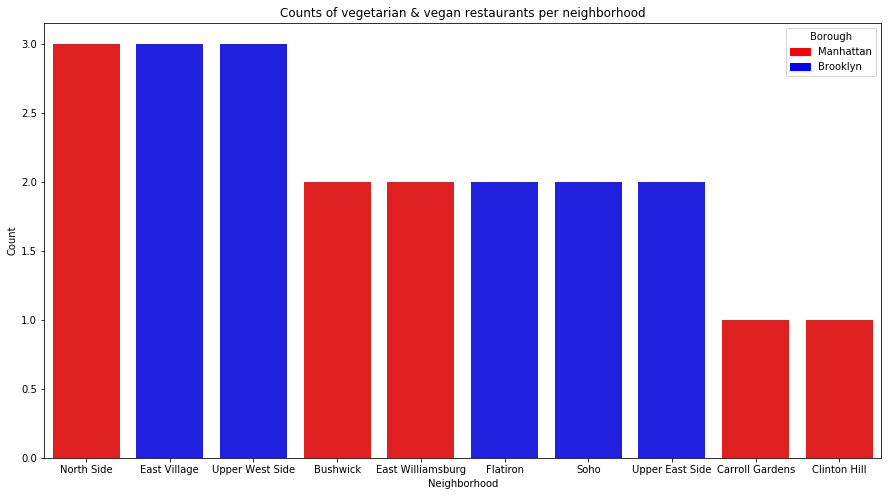

In [38]:
import seaborn as sns
from matplotlib import pyplot
import matplotlib.patches as mpatches
#Legend setting
red_patch = mpatches.Patch(color='red', label='Brooklyn')
blue_patch = mpatches.Patch(color='blue', label='Manhatten')
#Color Palette
palette_dir = {"Brooklyn":"r", "Manhattan": "b"}
ax = pyplot.subplots(figsize=(15,8))
ax = sns.barplot(x="Neighborhood", y="Count",data=count_by_neigh_df,palette=count_by_neigh_df["Borough"].map(palette_dir)).set_title("Counts of vegetarian & vegan restaurants per neighborhood")
plt.legend(handles=[red_patch, blue_patch], title='Borough', loc='upper right', labels=['Manhattan', 'Brooklyn'])

#### The 10 neighborhoods with the most vegetarian/vegan restaurants lay all in Manhatten and Brooklyn. 

#### Now the final density map will be created. At first I count the number of veggi restaurants per borough. Than the total number of restaurants in each borough. Than I devide both and get a density in percent of vegetarian/vegan restaurants per total number of restaurantsin each borough

In [41]:
count_df = manhattan_venues[manhattan_venues['Cat_Name']=='Vegetarian / Vegan Restaurant'].groupby('Borough').count()
count_df

Neighborhood  Venue_ID  Venue_Name  Cat_Name
Borough                                                    
Brooklyn                 14        14          14        14
Manhattan                23        23          23        23
Queens                    5         5           5         5
Staten Island             1         1           1         1

In [42]:
total_count_df = manhattan_venues[manhattan_venues['Cat_Name'].str.contains('Restaurant')].groupby('Borough').count()
total_count_df

Neighborhood  Venue_ID  Venue_Name  Cat_Name
Borough                                                    
Bronx                   273       273         273       273
Brooklyn                666       666         666       666
Manhattan               940       940         940       940
Queens                  588       588         588       588
Staten Island           158       158         158       158

In [43]:
density_df = count_df/total_count_df *100
density_df.fillna(0, inplace=True)
density_df= density_df.rename(columns={'Neighborhood':'Density of vegeterian restaurants'})
density_df.reset_index(level=0, inplace=True)
density_df

Borough  Density of vegeterian restaurants  Venue_ID  Venue_Name  \
0          Bronx                           0.000000  0.000000    0.000000   
1       Brooklyn                           2.102102  2.102102    2.102102   
2      Manhattan                           2.446809  2.446809    2.446809   
3         Queens                           0.850340  0.850340    0.850340   
4  Staten Island                           0.632911  0.632911    0.632911   

   Cat_Name  
0  0.000000  
1  2.102102  
2  2.446809  
3  0.850340  
4  0.632911

In [46]:
from IPython.display import display
  
geolocator = Nominatim(user_agent="veggi_in_ny")
location = geolocator.geocode('New York')
lat = location.latitude
lon = location.longitude

veggi_map = folium.Map(location=[lat, lon], zoom_start=10)

veggi_map.choropleth(
    geo_data=ny_geo_data,
    data=density_df,
    columns=['Borough', 'Density of vegeterian restaurants'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Density'
)
display(veggi_map)
#veggi_map.save('borough_rating.html')

#### Now it can visually be assessed that Brooklyn and Manhatten, which lay in the center of the city, offer the highest density of vegetarian and vegan restaurants in NYC, followed by Staten Island and Queens. There is not one single vegetarian or vegan restaurant represented in the Bronx in the north of NYC. 

## Results

Manhatten and Brooklyn offer the highest density, and the highest total number of vegetarian and vegan restaurants. They also include the 5 neighborhoods with the highest total numbers among all neighborhoods. Queens and Staten Island offer much fewer restaurants and there is not one vegetarian or vegan restaurant in the Bronx within 500m radius arund each of its neighborhoods. 

## Discussion of the results

There are some assumptions made in this analysis that limit its explanatory power. The numbers for each restaurants only include counts within a 500m defined radius around each neighborhood. Also no statement about the purchasing power within each neighborhood can be made. Further, lots of potentially important variables are omitted. The analysis still offers a broad assessment of NYC's vegetarian and vegan restaurant scenery. The results might be interesting not only for potential restaurant owners but also for interested tourists visiting the city. While in NYC it seems that the number of vegetarian and vegan restaurants are relatively uneven distributed among the neighborhoods (only 32 out of 300 neighborhoods offer a vegetarian/vegan choice), it would be interesting to see how the respective food scenery is represented in other big cities in the world.

## Sources

https://www.statista.com/topics/3377/vegan-market/  
https://cocl.us/new_york_dataset  
https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=GeoJSON
